In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install transformers torch torchvision matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, Subset
from transformers import BertTokenizer, BertModel, ViTModel
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO
from PIL import Image as PILImage
from IPython.display import Image, display
from torchvision.utils import save_image,make_grid
from torchvision.transforms import Resize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define the Hybrid Image Encoder
class HybridImageEncoder(nn.Module):
    def __init__(self):
        super(HybridImageEncoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),  # 224 -> 112
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 112 -> 112
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # 112 -> 112
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 3, kernel_size=3, stride=1, padding=1),  # 112 -> 112
            nn.BatchNorm2d(3),
            nn.ReLU(),
        )
        self.resize = Resize((224, 224))
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.fc = nn.Linear(768, 512)

    def forward(self, x):        
        x = self.conv_layers(x)  # Ensure output size [batch_size, 3, 224, 224]
        x = self.resize(x) 
        x = self.vit(pixel_values=x).last_hidden_state[:, 0]  # CLS token
        x = self.fc(x)
        return x



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
 #Define the Text Encoder
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(768, 512)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.fc(pooled_output)
        return output


In [5]:
# Define the Generator
import torch.nn.functional as F
class Generator(nn.Module):
    def __init__(self, text_dim, noise_dim, image_channels):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(text_dim + noise_dim, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 4096)
        self.fc4 = nn.Linear(4096, image_channels * 64 * 64)
        self.image_channels = image_channels

    def forward(self, text_features, noise):
        x = torch.cat((text_features, noise), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = x.view(-1, self.image_channels, 64, 64)
        return x

# Define the Enhanced Discriminator
class EnhancedDiscriminator(nn.Module):
    def __init__(self, image_channels,feature_dim):
        super(EnhancedDiscriminator, self).__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(image_channels + feature_dim, 128, 4, 2, 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(128, 256, 4, 2, 1))
        self.conv3 = nn.Conv2d(256, 512, 4, 2, 1)
        self.conv4 = nn.Conv2d(512, 1024, 4, 2, 1)
        self.fc1 = nn.Linear(1024* 4 * 4, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, image, features):
        # Concatenate image and features along the channel dimension
        features = features.unsqueeze(2).unsqueeze(3).expand(-1, -1, image.size(2), image.size(3))
        combined_input = torch.cat((image, features), dim=1)
        x = F.leaky_relu(self.conv1(combined_input),0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x), 0.2)
       # x = torch.sigmoid(self.fc2(x))
        return self.fc2(x)


In [6]:
# Initialize models
text_dim = 512
noise_dim = 100
image_channels = 3
feature_dim = 512

generator = Generator(text_dim, noise_dim, image_channels).to(device)
discriminator = EnhancedDiscriminator(image_channels, feature_dim).to(device)
hybrid_encoder = HybridImageEncoder().to(device)
text_encoder = TextEncoder().to(device)

# Optimizers
from torch.optim import Adam
optimizer_G = Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Loss function
adversarial_loss = nn.BCELoss()

# Load the dataset (COCO subset or any small dataset)
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.49139968, 0.48215827 ,0.44653124], std=[0.24703233,0.24348505,0.26158768])
])

# Class labels for CIFAR-10 dataset
cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Filter to keep only images of the class "cat"
target_class = 3  # "cat" class index
cat_indices = np.where(np.array(dataset.targets) == target_class)[0]  # Get indices of all "cat" images

cat_subset_dataset = Subset(dataset, cat_indices)

#subset_indices = list(range(2500))  # Use only 100 samples for quicker training
#subset_dataset = Subset(dataset, subset_indices)
dataloader = DataLoader(cat_subset_dataset, batch_size=16, shuffle=True)
print(f"Number of 'cat' images: {len(dataloader)}")
print(f"Number of 'cat' images: {len(cat_indices)}")


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

100%|██████████| 170498071/170498071 [00:10<00:00, 15978777.80it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Number of 'cat' images: 313
Number of 'cat' images: 5000


In [7]:
def gradient_penalty(discriminator, real_samples, fake_samples, real_image_features):
    batch_size = real_samples.size(0)
    epsilon = torch.rand(batch_size, 1, 1, 1).to(real_samples.device)
    
    # Interpolation between real and fake samples
    interpolates = (epsilon * real_samples + (1 - epsilon) * fake_samples).requires_grad_(True)
    
    # Get discriminator output for interpolated samples
    d_interpolates = discriminator(interpolates, real_image_features)
    
    # Create a gradient of ones to compute gradients
    fake = torch.ones_like(d_interpolates).to(real_samples.device)
    
    # Compute gradients w.r.t interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    # Reshape the gradients for computation
    gradients = gradients.view(batch_size, -1)
    
    # Compute the gradient penalty
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Wasserstein Loss for Discriminator
def discriminator_loss(real_preds, fake_preds):
    return -(torch.mean(real_preds) - torch.mean(fake_preds))

# Wasserstein Loss for Generator
def generator_loss(fake_preds):
    return -torch.mean(fake_preds)


/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/100], d_loss: 28.68319320678711, g_loss: -3.7832112312316895


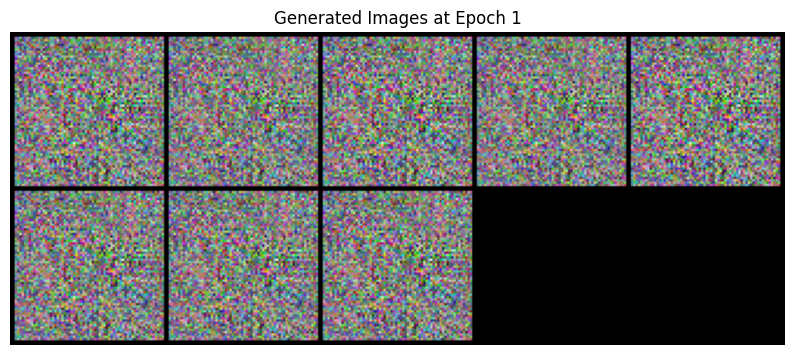

Epoch [2/100], d_loss: 25.12610626220703, g_loss: 4.820661544799805
Epoch [3/100], d_loss: 31.479087829589844, g_loss: -11.047845840454102
Epoch [4/100], d_loss: 26.547752380371094, g_loss: 23.428447723388672
Epoch [5/100], d_loss: 37.56864547729492, g_loss: 15.224946975708008
Epoch [6/100], d_loss: 24.493785858154297, g_loss: -51.896240234375
Epoch [7/100], d_loss: 27.048725128173828, g_loss: 2.0359914302825928
Epoch [8/100], d_loss: 21.47324562072754, g_loss: 10.580156326293945
Epoch [9/100], d_loss: 16.819223403930664, g_loss: 33.16014862060547
Epoch [10/100], d_loss: 41.96705627441406, g_loss: -11.751712799072266
Epoch [11/100], d_loss: 59.582054138183594, g_loss: -98.79788208007812
Epoch [12/100], d_loss: 32.72825622558594, g_loss: -12.324185371398926
Epoch [13/100], d_loss: 24.466819763183594, g_loss: -4.442562580108643
Epoch [14/100], d_loss: 12.111016273498535, g_loss: -3.011190414428711
Epoch [15/100], d_loss: 18.521846771240234, g_loss: -6.0670905113220215
Epoch [16/100], d_l

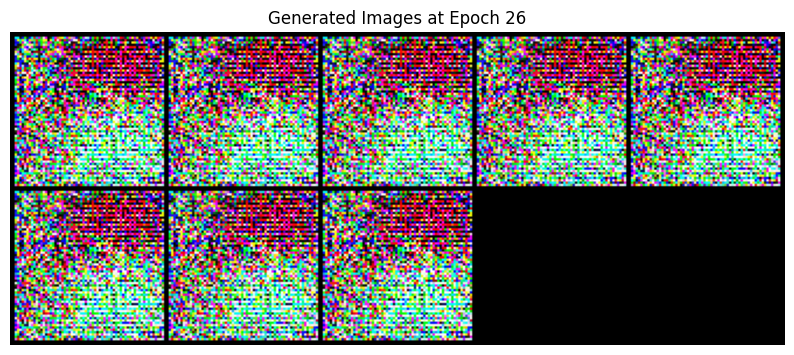

Epoch [27/100], d_loss: 26.125656127929688, g_loss: -54.079566955566406
Epoch [28/100], d_loss: 18.657880783081055, g_loss: -0.18665620684623718
Epoch [29/100], d_loss: 18.271183013916016, g_loss: -2.5348477363586426
Epoch [30/100], d_loss: 16.706281661987305, g_loss: -16.905071258544922
Epoch [31/100], d_loss: 11.468083381652832, g_loss: 12.070398330688477
Epoch [32/100], d_loss: 76.4330825805664, g_loss: -150.85191345214844
Epoch [33/100], d_loss: 26.439674377441406, g_loss: 13.022544860839844
Epoch [34/100], d_loss: 28.9854736328125, g_loss: -14.321977615356445
Epoch [35/100], d_loss: 22.170379638671875, g_loss: -5.618612289428711
Epoch [36/100], d_loss: 25.661575317382812, g_loss: 1.6463212966918945
Epoch [37/100], d_loss: 23.5021915435791, g_loss: 0.7882702946662903
Epoch [38/100], d_loss: 27.386741638183594, g_loss: 0.9857930541038513
Epoch [39/100], d_loss: 17.77182388305664, g_loss: -2.5293755531311035
Epoch [40/100], d_loss: 20.597007751464844, g_loss: -17.075870513916016
Epoc

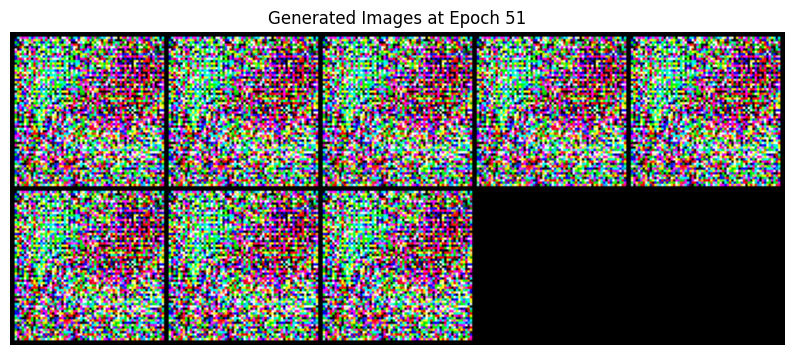

Epoch [52/100], d_loss: 16.41670799255371, g_loss: 2.904613733291626
Epoch [53/100], d_loss: 12.51612377166748, g_loss: -12.993403434753418
Epoch [54/100], d_loss: 17.326038360595703, g_loss: -4.633767127990723
Epoch [55/100], d_loss: 19.270471572875977, g_loss: 8.743009567260742
Epoch [56/100], d_loss: 18.506919860839844, g_loss: -9.638348579406738
Epoch [57/100], d_loss: 21.33728790283203, g_loss: 8.876399993896484
Epoch [58/100], d_loss: -56.47142028808594, g_loss: 114.9783935546875
Epoch [59/100], d_loss: 20.745847702026367, g_loss: -3.436030387878418
Epoch [60/100], d_loss: -34364.859375, g_loss: 267379.5
Epoch [61/100], d_loss: 37.947410583496094, g_loss: -60.78749084472656
Epoch [62/100], d_loss: 288.3875427246094, g_loss: -791.946044921875
Epoch [63/100], d_loss: 63.411163330078125, g_loss: -31.196182250976562
Epoch [64/100], d_loss: 109.52970123291016, g_loss: 59.983436584472656
Epoch [65/100], d_loss: 121.16822814941406, g_loss: -172.64785766601562
Epoch [66/100], d_loss: 46.

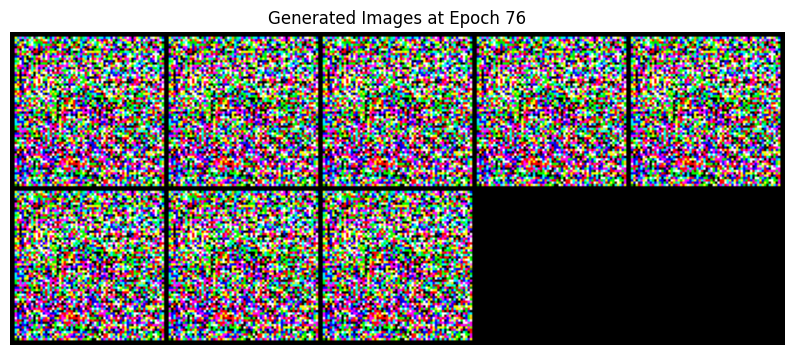

Epoch [77/100], d_loss: 346.33795166015625, g_loss: 727.843505859375
Epoch [78/100], d_loss: 98.18782043457031, g_loss: -63.33138656616211
Epoch [79/100], d_loss: 280.73919677734375, g_loss: -1012.8460693359375
Epoch [80/100], d_loss: -1.016451358795166, g_loss: -227.50819396972656
Epoch [81/100], d_loss: 65.80354309082031, g_loss: -44.94606018066406
Epoch [82/100], d_loss: 39.501487731933594, g_loss: -199.48269653320312
Epoch [83/100], d_loss: 34.37635040283203, g_loss: 73.41975402832031
Epoch [84/100], d_loss: 200.57298278808594, g_loss: -126.16961669921875
Epoch [85/100], d_loss: 24.186552047729492, g_loss: 33.82706832885742
Epoch [86/100], d_loss: 13.205493927001953, g_loss: 128.2654266357422
Epoch [87/100], d_loss: 30.75003433227539, g_loss: 51.91082763671875
Epoch [88/100], d_loss: 19.409996032714844, g_loss: -48.28441619873047
Epoch [89/100], d_loss: 126.02079772949219, g_loss: -235.0330810546875
Epoch [90/100], d_loss: 95.31553649902344, g_loss: 23.75507354736328
Epoch [91/100]

In [8]:
import os

# Create the 'images' directory if it does not exist
if not os.path.exists('images'):
    os.makedirs('images')

# Training loop
lambda_gp = 20
epochs = 100

for epoch in range(epochs):
    for images, labels in dataloader:
        images = images.to(device)
        batch_size = images.size(0)

        # Extract features using the Hybrid Image Encoder
        real_image_features = hybrid_encoder(images)

        # Prepare text input
        captions = [f"An image of a {cifar10_classes[label]}." for label in labels]
        tokenizer_output = tokenizer(captions, return_tensors='pt', padding='max_length', truncation=True, max_length=64)
        input_ids = tokenizer_output['input_ids'].to(device)
        attention_mask = tokenizer_output['attention_mask'].to(device)

        ### Train Discriminator ###
        optimizer_D.zero_grad()
        
        # Generate fake images for the current batch
        noise = torch.randn(batch_size, noise_dim).to(device)
        text_features = text_encoder(input_ids, attention_mask)
        generated_images = generator(text_features, noise)
        
        # Ensure tensors are on the correct device
        #generated_images = generated_images.to(device)

        # Extract features from generated images
        fake_image_features = hybrid_encoder(generated_images)

        # Discriminator on real and fake images
        real_preds = discriminator(images, real_image_features)
        fake_preds = discriminator(generated_images.detach(), fake_image_features)

        # Compute Wasserstein loss for discriminator
        d_loss = discriminator_loss(real_preds, fake_preds)

        # Compute gradient penalty
        gp = gradient_penalty(discriminator, images, generated_images.detach(), real_image_features)

        # Total discriminator loss
        total_d_loss = d_loss + lambda_gp * gp

        # Backpropagate and update discriminator
        total_d_loss.backward(retain_graph=True)
        optimizer_D.step()
        
        ### Train Generator ###
        optimizer_G.zero_grad()

        # Get new fake predictions (after discriminator update)
        fake_preds = discriminator(generated_images, fake_image_features)

        # Wasserstein loss for generator
        g_loss = generator_loss(fake_preds)

        # Backpropagate and update generator
        g_loss.backward()
        optimizer_G.step()

       # print(f"Generator gradients: {generator.fc1.weight.grad}")

    print(f'Epoch [{epoch+1}/{epochs}], d_loss: {total_d_loss.item()}, g_loss: {g_loss.item()}')
    save_image(generated_images.data[:10], f'images/{epoch+1}.png', nrow=5, normalize=True)

    # Display generated images every 25 epochs
    if epoch % 25 == 0:
        plt.figure(figsize=(10, 10))
        plt.axis('off')
        plt.title(f'Generated Images at Epoch {epoch+1}')
        grid = make_grid(generated_images.data[:10], nrow=5, normalize=True)
        plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
        plt.show()


### Example test prompt for the "cat" class
test_prompt = "An image of a cat sitting on a sofa."

# Tokenize the test prompt
tokenizer_output = tokenizer(test_prompt, return_tensors='pt', padding='max_length', truncation=True, max_length=64)
input_ids = tokenizer_output['input_ids'].to(device)
attention_mask = tokenizer_output['attention_mask'].to(device)

# Generate images based on the test prompt using the trained generator
noise = torch.randn(1, noise_dim).to(device)
text_features = text_encoder(input_ids, attention_mask)
generated_image = generator(text_features, noise)

# Display the generated image
import matplotlib.pyplot as plt
plt.imshow(np.transpose(generatExample test prompt for the "cat" class
test_prompt = "An image of a cat sitting on a sofa."

Tokenize the test prompt
tokenizer_output = tokenizer(test_prompt, return_tensors='pt', padding='max_length', truncation=True, max_length=64) input_ids = tokenizer_output['input_ids'].to(device) attention_mask = tokenizer_output['attention_mask'].to(device)

Generate images based on the test prompt using the trained generator
noise = torch.randn(1, noise_dim).to(device) text_features = text_encoder(input_ids, attention_mask) generated_image = generator(text_features, noise)

Display the generated image
import matplotlib.pyplot as plt plt.imshow(np.transpose(generated_image.detach().cpu().numpy()[0], (1, 2, 0))) plt.show()ed_image.detach().cpu().numpy()[0], (1, 2, 0)))
plt.show()


In [9]:
#Example test prompt for the "cat" class
test_prompt = "An image of a cat sitting on a sofa."

#Tokenize the test prompt
tokenizer_output = tokenizer(test_prompt, return_tensors='pt', padding='max_length', truncation=True, max_length=64) input_ids = tokenizer_output['input_ids'].to(device) attention_mask = tokenizer_output['attention_mask'].to(device)

#Generate images based on the test prompt using the trained generator
noise = torch.randn(1, noise_dim).to(device) text_features = text_encoder(input_ids, attention_mask) generated_image = generator(text_features, noise)

#Display the generated image
import matplotlib.pyplot as plt
plt.imshow(np.transpose(generated_image.detach().cpu().numpy()[0], (1, 2, 0))) plt.show()


SyntaxError: invalid syntax (1535910483.py, line 5)

In [ ]:
print("Test image generation complete! Stopping the notebook.")

# Stop the notebook here
import sys
sys.exit()